In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'orbsummaryfeaturesxgbNorbits10000.0Nout1000window10/'
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [4]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.8658687200000001                                  
ERROR                                               
0.008220779715321674                                
HOLDOUT SCORE                                       
0.879226903191232                                   
SCORE:                                                                        
0.8902200999999998                                                            
ERROR                                                                         
0.006723346313902909                                                          
HOLDOUT SCORE                                                                 
0.9024051112414626                                                            
SCORE:                                                                        
0.88051016                                                                    
ERROR                                             

0.004712748652566168                                                           
HOLDOUT SCORE                                                                  
0.9094136844545742                                                             
SCORE:                                                                         
0.8915390999999999                                                             
ERROR                                                                          
0.005897007343072867                                                           
HOLDOUT SCORE                                                                  
0.9140062509581043                                                             
SCORE:                                                                         
0.8907082000000001                                                             
ERROR                                                                          
0.004620786817377992                    

0.007062670286995636                                                           
HOLDOUT SCORE                                                                  
0.9036872291177585                                                             
SCORE:                                                                         
0.8409595400000001                                                             
ERROR                                                                          
0.009750131940613188                                                           
HOLDOUT SCORE                                                                  
0.8625061603736892                                                             
SCORE:                                                                         
0.88276402                                                                     
ERROR                                                                          
0.0065561870381620115                   

In [6]:
best

{'x_learning_rate': 0.1830158624492142,
 'x_max_depth': 13,
 'x_min_child': 8.0,
 'x_pos_weight': 13.602944022012974,
 'x_subsample': 0.8968785555008084,
 'x_tree_colsample': 0.7296147404471879}

In [7]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.928464+0.0021993	test-auc:0.865267+0.0108171
[1]	train-auc:0.955679+0.00143372	test-auc:0.889126+0.00805272
[2]	train-auc:0.964882+0.00188862	test-auc:0.897005+0.0059567
[3]	train-auc:0.970988+0.00181713	test-auc:0.902761+0.00557367
[4]	train-auc:0.975703+0.00211998	test-auc:0.90674+0.00382844
[5]	train-auc:0.979118+0.00198423	test-auc:0.908436+0.00462941
[6]	train-auc:0.981844+0.00180021	test-auc:0.91111+0.00427072
[7]	train-auc:0.984114+0.00115011	test-auc:0.912745+0.00442322
[8]	train-auc:0.986257+0.00111576	test-auc:0.914783+0.00436877
[9]	train-auc:0.987782+0.00107547	test-auc:0.916775+0.00409126
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.928464       0.002199       0.865267      0.010817
1        0.955679       0.001434       0.889126      0.008053
2        0.964882       0.001889       0.897005      0.005957
3        0.970988       0.001817       0.902761      0.005574
4        0.975703       0.002120       0.906740      0.003828
5  

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.7944391755263701


In [8]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7296147404471879, gamma=0,
       learning_rate=0.1830158624492142, max_delta_step=0, max_depth=13,
       min_child_weight=8.0, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=13.602944022012974,
       seed=None, silent=True, subsample=0.8968785555008084)

Text(0.5, 1.0, 'ROC curve (AUC = 0.926)')

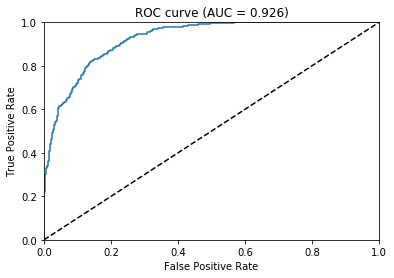

In [9]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [10]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.003368971636518836, recall = 1.0, precision = 0.39546783625730997
Threshold 0.003609768580645323, recall = 0.9981515711645101, precision = 0.3991130820399113
Threshold 0.004017970059067011, recall = 0.9981515711645101, precision = 0.40358744394618834
Threshold 0.004578521475195885, recall = 0.9981515711645101, precision = 0.40816326530612246
Threshold 0.005026665516197681, recall = 0.9963031423290203, precision = 0.4120795107033639
Threshold 0.005345778074115515, recall = 0.9963031423290203, precision = 0.4168600154679041
Threshold 0.005756653845310211, recall = 0.9963031423290203, precision = 0.4217527386541471
Threshold 0.006456313189119101, recall = 0.9963031423290203, precision = 0.4267616785431512
Threshold 0.0073372432962059975, recall = 0.9944547134935305, precision = 0.4310897435897436
Threshold 0.007834228686988354, recall = 0.9926062846580407, precision = 0.43552311435523117
Threshold 0.008803400211036205, recall = 0.9907578558225508, precision = 0.440065681444991

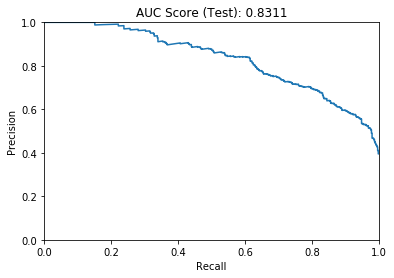

In [11]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 144.10000000000002)

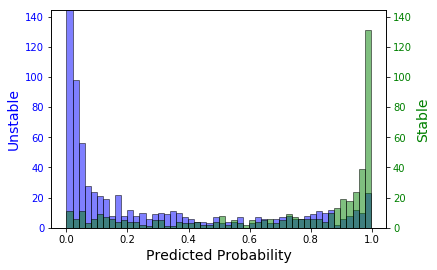

In [12]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

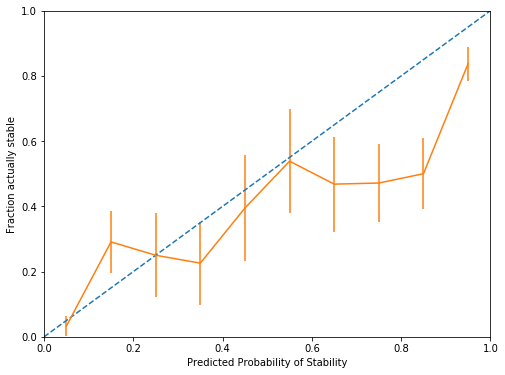

In [13]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

In [ ]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

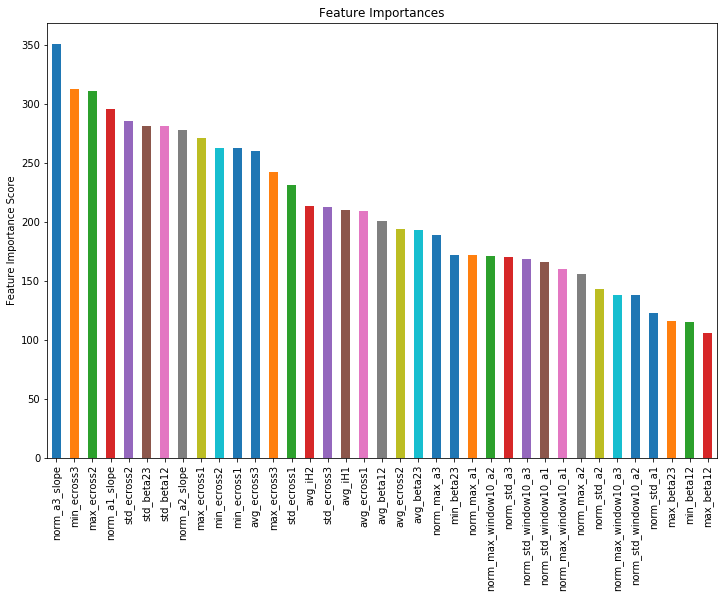

In [14]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [17]:
dill.dump([model, features, featurefolder], open(datapath+"../models/orbsummaryfeaturesxgb_resonant.pkl", "wb"))